In [12]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib import rcParams
import sympy as sy
import scipy.constants as pc
from sympy import *
from math import log10, floor

rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [2]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (unsicherheiten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

In [3]:
# Erinnerungen
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [4]:
# Quader
tief = 23.7
höh = 42.3
breit = 59.8
us_q = 0.1


# Einzelmessungen
t_b = np.array([11.1, 30.0, 49.0, 67.8, 87.3]) # 0.2 10³ ns
t_t = np.array([7.3, 18.2, 29.1, 40.9, 51.1]) # 0.2 10³ ns
t_h = np.array([15.0, 41.1])# 0.2 10³ ns
us_t = 0.2

breite = np.array([])
tiefe = np.array([])
höhe = np.array([höh, höh*2])

for i in range(t_b.size):
    ii = i+1
    breite = np.append(breite, breit*ii)
    tiefe = np.append(tiefe, tief*ii)
    
# Differenzquotienten

t_dif = (t_b-t_t)
t_dif_erg = np.array([t_b[0]-t_h[0], t_b[1]-t_h[1]])
t_dif = abs(np.append(t_dif, t_dif_erg))

s_dif = (breite-tiefe)
s_dif_erg = np.array([breite[0]-höhe[0], breite[1]-höhe[1]])
s_dif = abs(np.append(s_dif, s_dif_erg))

v_dif = s_dif/t_dif

print(s_dif)

# Messung mit Transversalwellen
#winkel =
#d = 
#t_1 = 


[ 36.1  72.2 108.3 144.4 180.5  17.5  35. ]


5.579343621212351
0.7425327757204742
geschwindigkeiten [9.5        6.11864407 5.44221106 5.36802974 4.98618785 4.48717949
 3.15315315]
strecken [ 36.1  72.2 108.3 144.4 180.5  17.5  35. ]


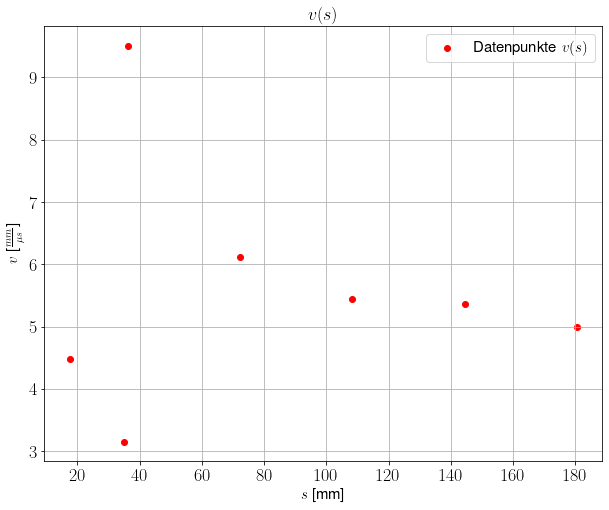

In [21]:
# Standard plotting

fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
ax.scatter(s_dif, v_dif, color='r', label=r'Datenpunkte $v(s)$')
#ax.scatter(höhe/t_h, t_h, color='b', label=r'Datenpunkte Höhe')
#ax.scatter(tiefe/t_t, t_t, color='g', label=r'Datenpunkte Tiefe')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, fmt='D', color='#d0740b', label='label')

ax.set(xlabel=r'$s$ [mm]', ylabel=r'$v$ [$\frac{mm}{\mu s}$]', title=r'$v(s)$')
ax.legend()
ax.grid()

print(am(v_dif))
print(stu(v_dif))
fig.savefig("v(s).png")

print('geschwindigkeiten', v_dif)
print('strecken', s_dif)

4.984949985041041 0.46986005028800615
3.9585259570482694 9.265659252919521
zeiten [ 3.8 11.8 19.9 26.9 36.2  3.9 11.1]
strecken [ 36.1  72.2 108.3 144.4 180.5  17.5  35. ]


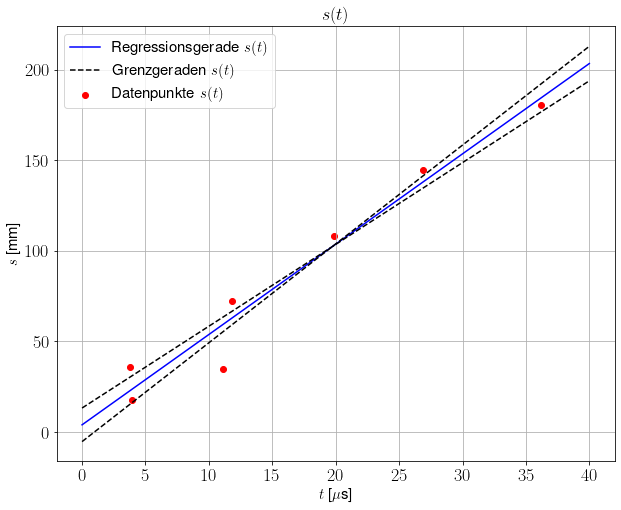

In [20]:
# Standard plotting

fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
ax.scatter(t_dif, s_dif, color='r', label=r'Datenpunkte $s(t)$')

x = np.linspace(0, 40, 40)

a, b = bestA(t_dif, s_dif), bestB(t_dif, s_dif)
us_a, us_b = stuA(t_dif, s_dif), stuB(t_dif, s_dif)
ax.plot(x, x*b+a, color='b', label=r'Regressionsgerade $s(t)$')
ax.plot(x, x*(b-us_b)+a+us_a, color='black', linestyle='--',label=r'Grenzgeraden $s(t)$')
ax.plot(x, x*(b+us_b)+a-us_a, color='black', linestyle='--')
#ax.scatter(höhe/t_h, t_h, color='b', label=r'Datenpunkte Höhe')
#ax.scatter(tiefe/t_t, t_t, color='g', label=r'Datenpunkte Tiefe')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, fmt='D', color='#d0740b', label='label')

ax.set(xlabel=r'$t$ [$\mu$s]', ylabel=r'$s$ [mm]', title=r'$s(t)$')
ax.legend()
ax.grid()

print(b, us_b)
print(a, us_a)
print('zeiten', t_dif)
print('strecken', s_dif)
fig.savefig("s(t).png")